# FRAUD DETECTION IN SUPPLY CHAIN

## OBJECTIVES:
Supply Chain is a network between company and its suppliers to produce and distribute final products to the buyer. Nowadays, many big companies are opting for supply chain. With the rise in business and technology, fraudulent activities have risen up too which eventually affects the business revenue. Detection of such fraud activities/transactions is crucial for any supply chain business. The main goal of this business problem is to identify and flag as many fraudulent orders as possible. 

# Import all the required libraries

In [8]:
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error, confusion_matrix
from category_encoders import LeaveOneOutEncoder
import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [9]:
df = pd.read_csv('./data/DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
pd.set_option('display.max_columns',None)
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


## DATA VISUALIZATION AND FEATURE ENGINEERING

In [10]:
def basic_info(df):
    print('Total data-points :',df.size)
    print('Total features: ',df.shape[1])
    numerical_features = [f for f in df.columns if df[f].dtypes!='O']
    print('Total numerical features :',len(numerical_features))
    cat_features = [c for c in df.columns if df[c].dtypes=='O']
    print('Total categorical features :',len(cat_features))
    print('Total rows: ',df.shape[0])
    print("\nFeature lists containing null values in percentage:\n")
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            print(column, ': {:.4%}'.format(df[column].isnull().sum() / df[column].shape[0]))
basic_info(df)

Total data-points : 9567507
Total features:  53
Total numerical features : 29
Total categorical features : 24
Total rows:  180519

Feature lists containing null values in percentage:

Customer Lname : 0.0044%
Customer Zipcode : 0.0017%
Order Zipcode : 86.2397%
Product Description : 100.0000%


##### I am going to create some functions to get the features based on their categories.

In [11]:
def getTotalCols(df):
    return df.columns.tolist()

def getCtgCols(df):
    cols = df.columns.tolist()
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))

def getNumCols(df):
    return df._get_numeric_data().columns

def getList(list_1,list_2):
    return list(set(list_1) - set(list_2))

### Numerical Feature Analysis

In [12]:
total_ftr = len(getTotalCols(df))
num_ftr = getNumCols(df)
    
print("\nNumerical features:\n")
for ftr in num_ftr:
    print(ftr)


Numerical features:

Days for shipping (real)
Days for shipment (scheduled)
Benefit per order
Sales per customer
Late_delivery_risk
Category Id
Customer Id
Customer Zipcode
Department Id
Latitude
Longitude
Order Customer Id
Order Id
Order Item Cardprod Id
Order Item Discount
Order Item Discount Rate
Order Item Id
Order Item Product Price
Order Item Profit Ratio
Order Item Quantity
Sales
Order Item Total
Order Profit Per Order
Order Zipcode
Product Card Id
Product Category Id
Product Description
Product Price
Product Status


##### The numerical features contains many ID related columns those seems identical to me. Such as Category ID and Product Category ID seems same to me. Benefit per order and Order Profit per order also sounds quiet similar. Let's find out the features those are highly correlated. 

In [13]:
#Display column pairs with correlation=1
def corrFtr(df,x):
    c = df.corr().abs().round(2)
    # Select upper triangle of correlation matrix
    c = c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
    #find column pairs with correlation = 1
    c = c.fillna(0)
    c = c.loc[(c<x).any(axis=1)] #removing rows with all less than x correlations
    c = c.loc[:, (c<x).any(axis=0)] #removing columns with all less than x correlations
    #display(c)
    display(c[c >= x].stack())
    return()

corrFtr(df, .8)

Benefit per order         Order Item Profit Ratio    0.82
                          Order Profit Per Order     1.00
Sales per customer        Sales                      0.99
                          Order Item Total           1.00
Category Id               Department Id              0.89
                          Order Item Cardprod Id     0.99
                          Product Card Id            0.99
                          Product Category Id        1.00
Customer Id               Order Customer Id          1.00
Customer Zipcode          Longitude                  0.92
Department Id             Order Item Cardprod Id     0.91
                          Product Card Id            0.91
                          Product Category Id        0.89
Order Id                  Order Item Id              1.00
Order Item Cardprod Id    Product Card Id            1.00
                          Product Category Id        0.99
Order Item Product Price  Product Price              1.00
Order Item Pro

()

##### It seems that ID related features are highly correlated with each other. Besides Sales and Order related features shows highly correlations  with some other features. Let's draw a heatMap to get a clear visualizations
### Draw Heatmap

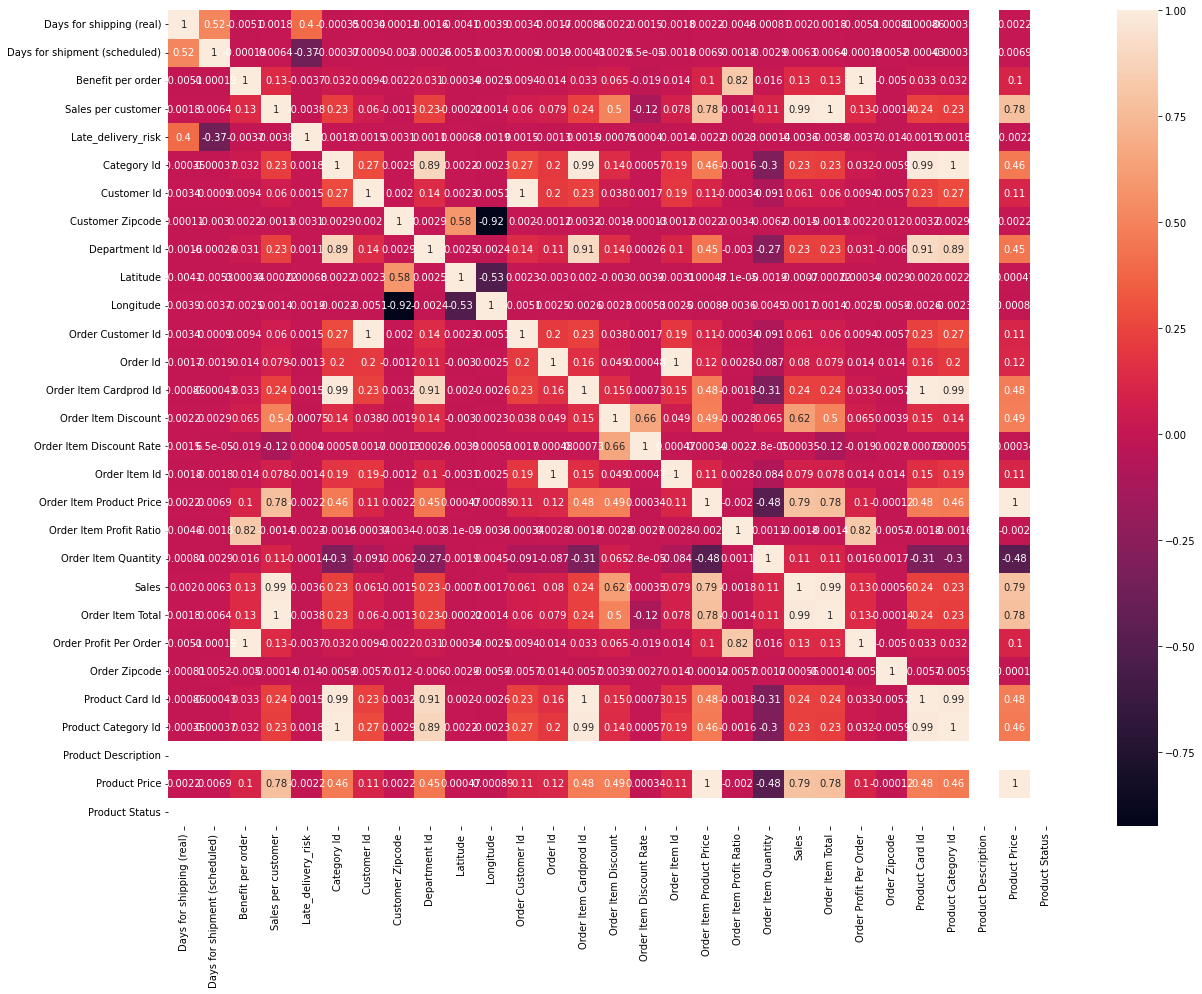

In [14]:
def heatMap(df_heatmap):
    ftr_corr = df_heatmap.corr()
    top_corr=ftr_corr.index
    plot.figure(figsize=(20,15))
    g=sns.heatmap(df_heatmap[top_corr].corr(),annot=True)
    df_heatmap.columns.tolist()
    
heatMap(df)

### Heatmap Analysis
##### Benefit per order feature contains negative values against Days for shipping(real) and Days for shipment(scheduled). That means negetavie benefit can be happend due to late delivery of the products. Moreover fraudulent transections also would be another reasons for negetive benefit per order. However, the total number of features in this data sets is 53 which quiet high to get a insights from heatmap analysis. Even not all features are required to the context of this projects.The current goal of this project is to detect fraudulent transections and clussify the fraud orders. That's why not all the columns are not necessary. So I am going to sortout unwanted/duplicate features those are not required. Removing those features will help to clearly identify the important features and get insights from existing features.
### Drop unwanted features

In [15]:
def dropCol(df,col_list):
    df.drop(col_list,axis=1,inplace=True)

col_list = ['Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Customer Id','Category Id','Customer Password','Customer Email',
            'Order Zipcode','Product Description','Order Item Product Price',
            'Department Id','Latitude','Longitude','Order Item Cardprod Id','Product Card Id','Product Category Id','Product Image','shipping date (DateOrders)',
            'Order Item Total','Sales','Product Status','Order Customer Id','Order Profit Per Order','Order Item Id','Order Id']
dropCol(df,col_list)
df.shape


(180519, 28)

### Categorical Feature Analysis

In [16]:
ctg_ftr = getCtgCols(df)

print("Categorical features:\n")
for ftr in ctg_ftr:
    print(ftr)

Categorical features:

Customer State
Order City
Order State
Order Status
Customer Street
Order Country
Order Region
Delivery Status
Category Name
Product Name
Shipping Mode
Department Name
Type
Customer Segment
Customer Fname
Customer Country
Customer Lname
Market
order date (DateOrders)
Customer City


### The categorical features can be devided into four categories:
  
**1. Customer related informations**

  * ['Customer Country','Customer Fname','Customer Lname','Customer Segment','Customer City','Customer State','Customer Street']

**2. Order related informations**

  * ['Order Region','Order Country','Order State','Order City']

**3. Product related informations**
  * ['Product Name','Department Name','Category Name','Market']

**4. Delivery / Shippig related informations**
  * ['Delivery Status','Type','Shipping Mode']
  
**5. Key Feature**
  * ['Order Status']
  

### Key Feature[Order Status]
##### Order Status is our key features. Let's see what are the other unique values this feature contains. 

In [17]:
df['Order Status'].unique()

array(['COMPLETE', 'PENDING', 'CLOSED', 'PENDING_PAYMENT', 'CANCELED',
       'PROCESSING', 'SUSPECTED_FRAUD', 'ON_HOLD', 'PAYMENT_REVIEW'],
      dtype=object)

##### If I merge the Customer Fname and Customer Lname into Customer Name, it would help to get more clear insights. So I am going to do that. 

In [18]:
df['Customer Name'] = df['Customer Fname'].astype(str)+" "+df['Customer Lname'].astype(str)
df.drop(['Customer Fname','Customer Lname'],axis=1,inplace=True)

In [19]:
customer_feature = ['Customer Country','Customer Name','Customer Segment','Customer City','Customer State','Customer Street']
order_feature = ['Order Region','Order Country','Order State','Order City']
product_feature = ['Product Name','Department Name','Category Name','Market']
shipping_feature = ['Type','Shipping Mode']
order_date = ['order date (DateOrders)']

ctg_cols = getCtgCols(df)
# df.head()

##### Let's just get a quick look from suspected fraud orders. 

In [20]:
df[(df['Order Status'] == "SUSPECTED_FRAUD")].head()

,Type,Benefit per order,Sales per customer,Delivery Status,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Name,Market,Order City,Order Country,order date (DateOrders),Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Order Region,Order State,Order Status,Product Name,Product Price,Shipping Mode,Customer Name
10,TRANSFER,130.580002,272.029999,Shipping canceled,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,4058 Quiet Heights,725.0,Fitness,Pacific Asia,Tokio,Japón,1/13/2018 9:18,55.720001,0.17,0.48,1,Eastern Asia,Tokio,SUSPECTED_FRAUD,Smart watch,327.750000,Second Class,Germane Short
24,TRANSFER,90.279999,288.420013,Shipping canceled,Sporting Goods,Billings,EE. UU.,Corporate,MT,3176 Round Gate,59102.0,Fitness,Pacific Asia,Brisbane,Australia,1/13/2018 4:24,39.330002,0.12,0.31,1,Oceania,Queensland,SUSPECTED_FRAUD,Smart watch,327.750000,Second Class,Simone Vance
183,TRANSFER,28.850000,128.220001,Shipping canceled,Electronics,Freeport,EE. UU.,Consumer,NY,3675 Emerald Goose Bank,11520.0,Footwear,USCA,Houston,Estados Unidos,5/8/2016 17:42,6.750000,0.05,0.23,3,US Center,Texas,SUSPECTED_FRAUD,Under Armour Men's Compression EV SL Slide,44.990002,Standard Class,Patricia Petersen
184,TRANSFER,133.910004,278.970001,Shipping canceled,Cardio Equipment,Fort Washington,EE. UU.,Consumer,MD,9375 Harvest Circuit,20744.0,Footwear,USCA,Gilbert,Estados Unidos,4/2/2016 19:51,21.000000,0.07,0.48,3,West of USA,Arizona,SUSPECTED_FRAUD,Nike Men's Free 5.0+ Running Shoe,99.989998,Standard Class,Julie Petersen
185,TRANSFER,79.160004,272.970001,Shipping canceled,Cardio Equipment,Bakersfield,EE. UU.,Consumer,CA,3993 Thunder Hills Port,93304.0,Footwear,USCA,San Jose,Estados Unidos,8/14/2016 2:51,27.000000,0.09,0.29,3,West of USA,California,SUSPECTED_FRAUD,Nike Men's Free 5.0+ Running Shoe,99.989998,Standard Class,Lisa Smith


##### Let's create a function to visualize the top fraudulent entities on each category

In [21]:
def top_fraudulent_ft(ctg_cols,n_largest,df = df[(df['Order Status'] == 'SUSPECTED_FRAUD')]):
    #Top 10 customers with most fraud
    for ctg_col in ctg_cols:
        df[ctg_col].value_counts().nlargest(n_largest).sort_values(ascending=True).plot.barh(figsize=(10,4), title="Top "+" fraudulent "+ ctg_col)
        plot.figure()

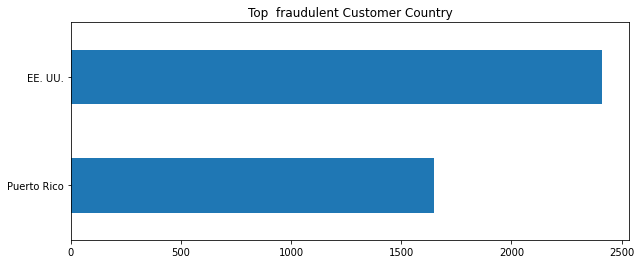

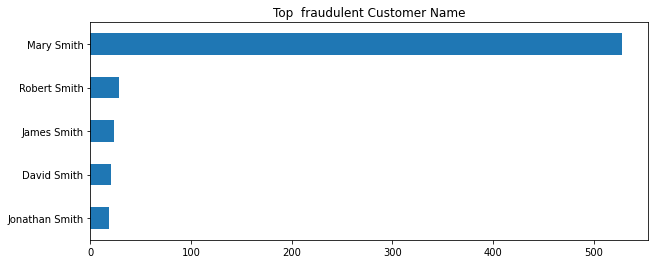

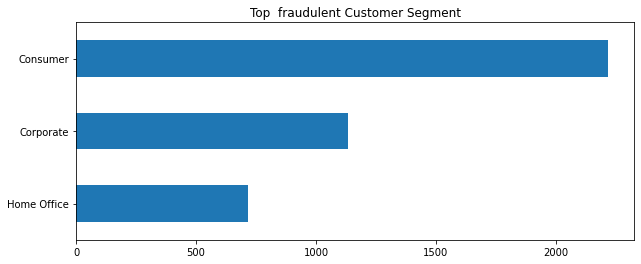

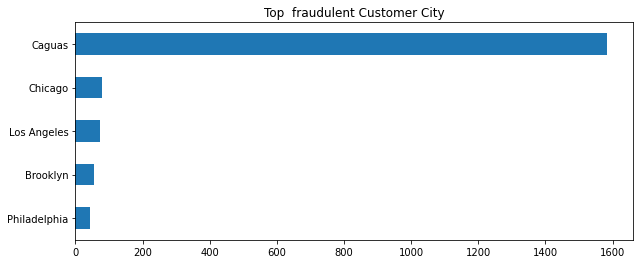

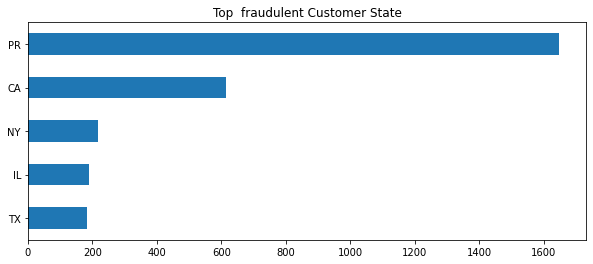

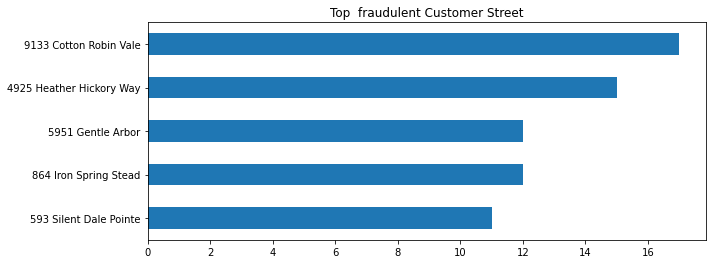

<Figure size 432x288 with 0 Axes>

In [22]:
top_fraudulent_ft(customer_feature,5)

##### It seems that all fraudulent orders came from only two countries EE.UU and Puerto Rico. Where as top three fraudulent states are PR, CA, NY which are codenames of Puerto Rico, California and New york. But the US is not present in the top fraudulent customers country. Let's see what are the others customers country presents in this data sets.

In [23]:
customer_country = df[(df['Order Status']=='SUSPECTED_FRAUD')]['Customer Country'].unique().tolist()
print("Customer countries:",customer_country)


Customer countries: ['Puerto Rico', 'EE. UU.']


In [24]:
order_country = df[(df['Order Status']=='SUSPECTED_FRAUD')]['Order Country'].unique().tolist()
print("Number of order countries:",len(order_country))

Number of order countries: 102


##### Customer Country column contains only two values, where Order Country columns contains 102 values. It is obvious that Customer Country column is defected and contain false values. So I need to delete this feature later.

In [25]:
df.drop(['Customer Country'],axis=1,inplace=True)

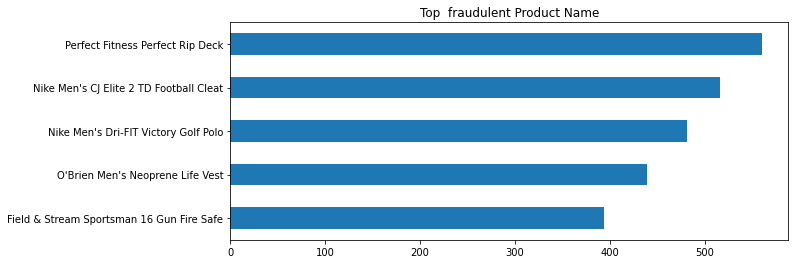

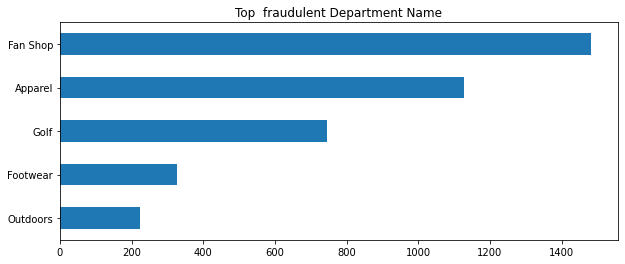

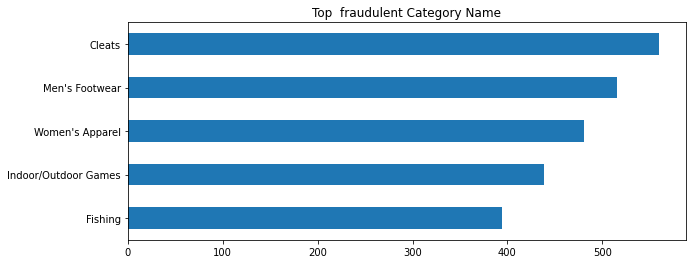

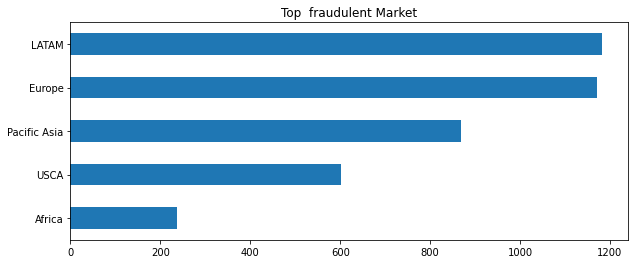

<Figure size 432x288 with 0 Axes>

In [26]:
top_fraudulent_ft(product_feature,5)

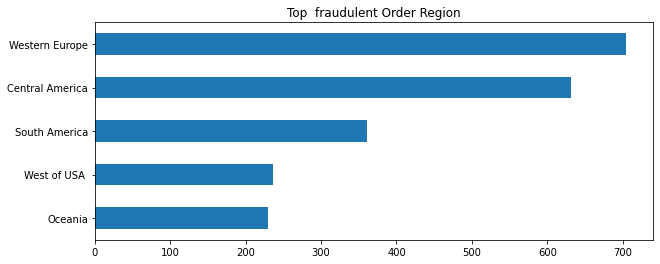

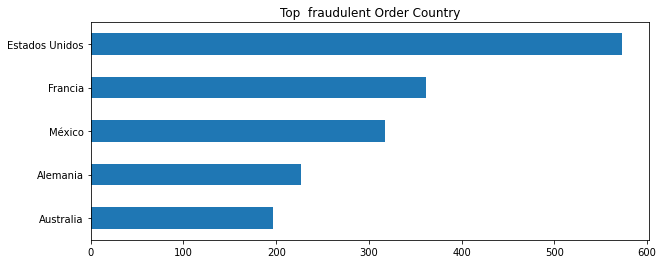

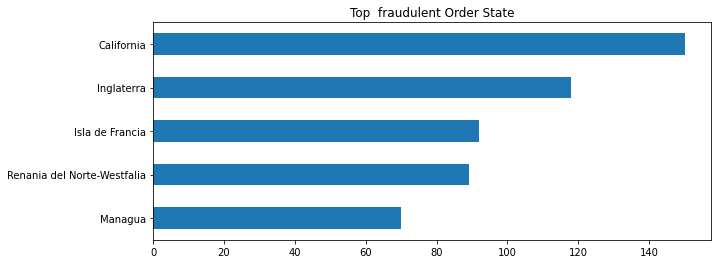

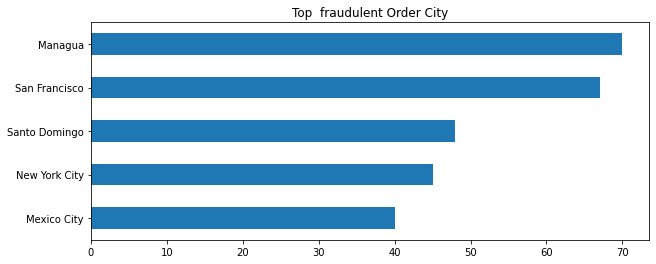

<Figure size 432x288 with 0 Axes>

In [27]:
top_fraudulent_ft(order_feature,5)

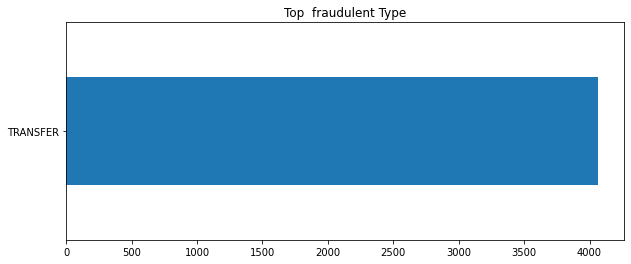

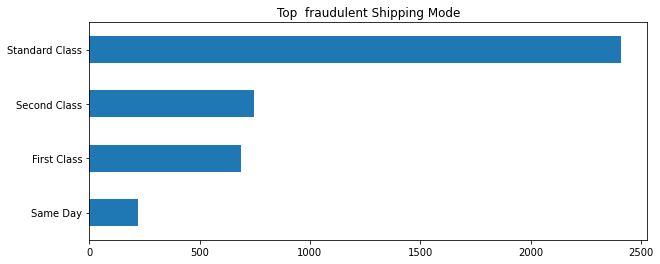

<Figure size 432x288 with 0 Axes>

In [28]:
top_fraudulent_ft(shipping_feature,5)

##### Let,s pick the top fraud customer and do more further investigations. The top fraud suspected fraud customer is:- Mary Smith

In [29]:
df_fraud = df[(df['Customer Name'] == 'Mary Smith')&(df['Order Status'] =='SUSPECTED_FRAUD')]

fraud_location = ['Customer City','Customer State','Customer Street',
                       'Order Region','Order Country','Order State','Order City']
fraud_product = ['Product Name','Department Name','Category Name','Market']
fraud_shipping = ['Type','Shipping Mode']

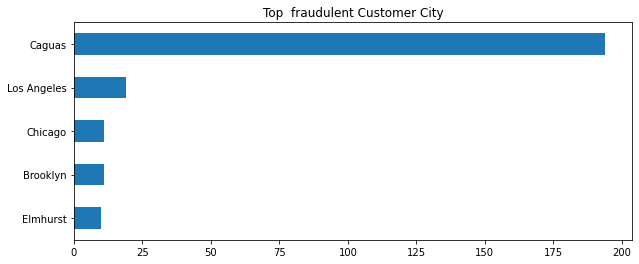

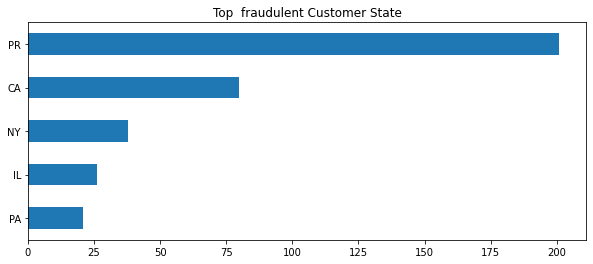

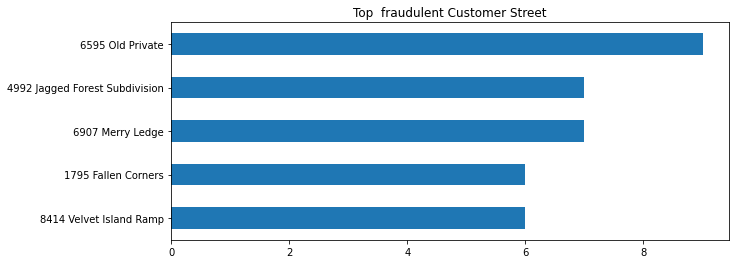

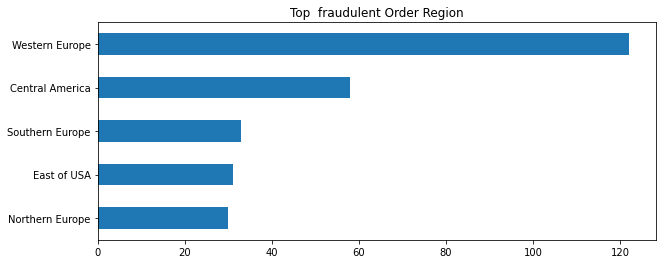

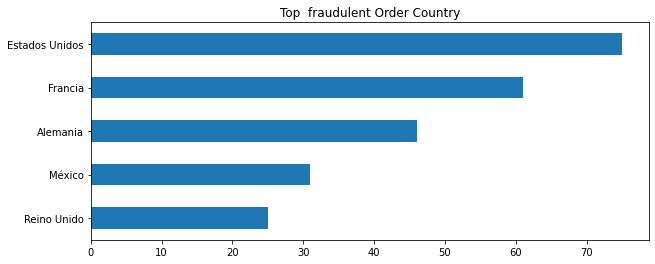

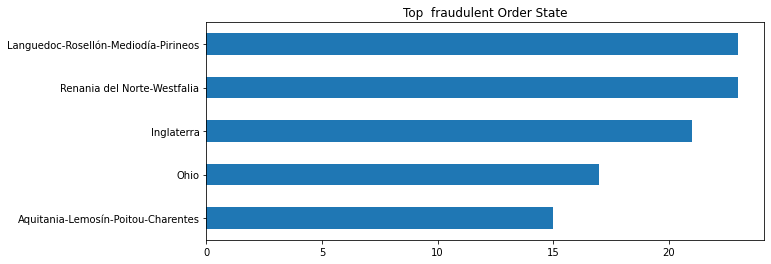

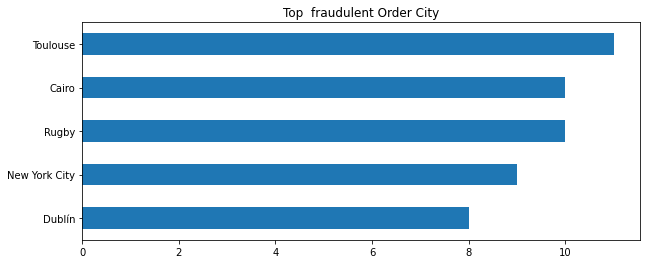

<Figure size 432x288 with 0 Axes>

In [30]:
top_fraudulent_ft(fraud_location,5,df_fraud)

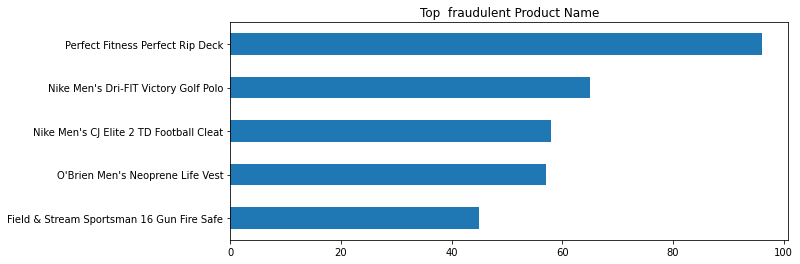

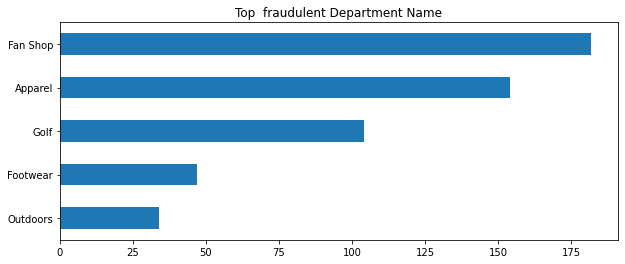

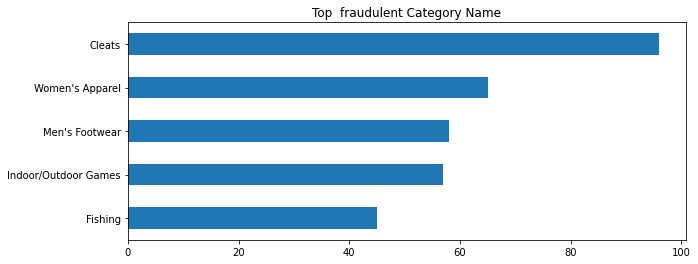

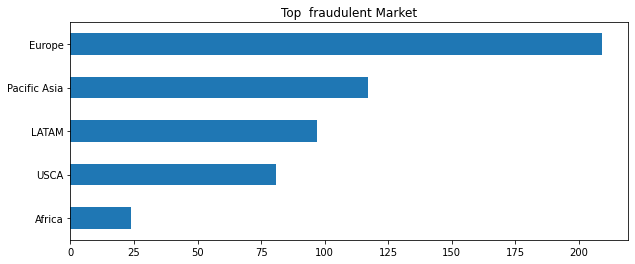

<Figure size 432x288 with 0 Axes>

In [31]:
top_fraudulent_ft(fraud_product,5,df_fraud)

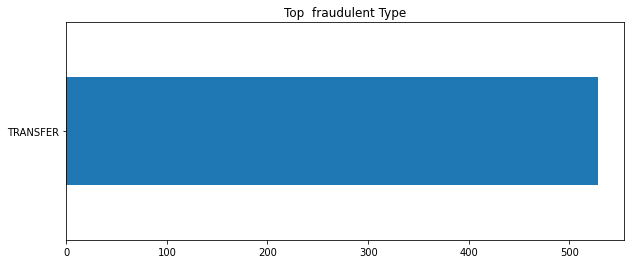

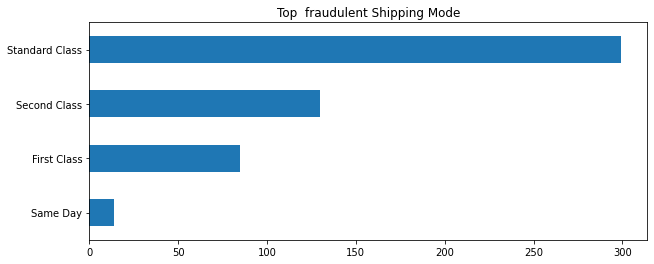

<Figure size 432x288 with 0 Axes>

In [32]:
top_fraudulent_ft(fraud_shipping,5,df_fraud)

## Investigation of Mary Smith:
**1. Locations:**
  * Mary Smith's living location(Ex: Customer City, Customer State) is totally different from his/her order locations(Ex: Order City, Order State).
  
**2. Products:**
  * Most of the products fall into Cleats and Womens Apparel

**3. Payment Type and Shipping Methods:**
  * The only Payment type is used by Mary Smith is TRANSFER
  * The most of the Shipping Method is used by Mary Smith is Standard Class

# MODELING
## Important Feature to bulid model:
**1. customer_feature:**
  * ['Customer Country','Customer Name','Customer Segment','Customer City','Customer State','Customer Street'].
  
**2. order_feature:**
  * ['Order Region','Order Country','Order State','Order City']

**3. product_feature:**
  * ['Product Name','Department Name','Category Name','Market']
  
**4. shipping_feature:**
  * ['Type','Shipping Mode']

### Drop Null Rows
###### Customer Lname, Customer Fname, Customer Zipcode contains very few number of null values. Dropping those few number of null values won't affect the quality of dataset that much

In [33]:
def dropNullRows(df,col_list):
        df.dropna(axis=0,inplace=True)
    

# col_list = ['Customer Lname','Customer Fname','Customer Zipcode']
dropNullRows(df,col_list)

In [34]:
df_model = df.copy()
customer_feature = ['Customer Name','Customer Segment','Customer City','Customer State','Customer Street']
order_feature = ['Order Region','Order Country','Order State','Order City']
product_feature = ['Product Name','Department Name','Category Name','Market']
shipping_feature = ['Type','Shipping Mode']
  

### Target Column - FRAUD
This feature has been created from column **'Order Status'** in which values are flagged as fraud on the basis of  **'SUSPECTED_FRAUD'**.

In [35]:
df_model['Fraud'] = np.where(df_model['Order Status'] == 'SUSPECTED_FRAUD',1,0)
df_model.drop(['Order Status'],axis=1,inplace=True)
target = df_model[['Fraud']].copy()
df_model.drop(['Fraud'],axis=1,inplace=True)

In [36]:

ctg_cols = getCtgCols(df_model)
model_ftr = getList(ctg_cols,customer_feature+order_feature+product_feature+shipping_feature)
df_model.drop(model_ftr,axis=1,inplace=True)
enc = LeaveOneOutEncoder(cols = customer_feature + order_feature + product_feature + shipping_feature)
df_model = enc.fit_transform(df_model, target)

### Split The Dataset for Training && Testing Purpose. 

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df_model,target,test_size=.25,random_state=0)

## Data Modeling 
### Random Forest Classifier

In [38]:
model_rfc = RandomForestClassifier(random_state=0)

model_rfc.fit(x_train,y_train)
y_pred = model_rfc.predict(x_test)
score = r2_score(y_test,y_pred)


## Model Evaluation

In [39]:
def modelEva(y_test,y_pred):
    score =r2_score(y_test,y_pred)
    ms_error =mean_squared_error(y_test,y_pred)
    ma_error =mean_absolute_error(y_test,y_pred)
    print("Mean Squared Error: ","{:.2f}%".format(ms_error * 100))
    print("Mean Absolute Error: ","{:.2f}%".format(ma_error * 100))
    print("Accuracy: ","{:.2f}%".format(score * 100))
modelEva(y_test,y_pred)

Mean Squared Error:  0.00%
Mean Absolute Error:  0.00%
Accuracy:  100.00%


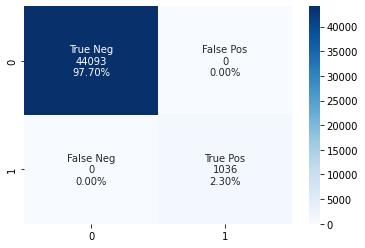

In [40]:
def get_confusion_matrix(y_test,y_pred):
    
    cf_matrix = confusion_matrix(y_test,y_pred)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    
get_confusion_matrix(y_test,y_pred)

### References: 
###### Kenton, W. (2021, August 29). Supply Chain. Investopedia. Retrieved January 5, 2022, from https://www.investopedia.com/terms/s/supplychain.asp
###### T, D. (2019, July 25). Confusion Matrix Visualization. Medium. Retrieved January 5, 2022, from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
##### Bastos, R. (2021, August 23). Boost your Data Analysis with Pandas. Towardsdatascience. Retrieved January 5, 2022, from https://towardsdatascience.com/boost-your-data-analysis-with-pandas-69c4be5d73bb
##### https://github.com/simranjeetkaurgahir/Fraud_detection.git
